In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import (
    Dense,
    BatchNormalization,
    Dropout,
    Flatten,
    Rescaling,
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    LeakyReLU,
    GlobalAveragePooling2D,
    RandomZoom,
    RandomContrast
)
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from PIL import Image
import shutil
from sklearn.utils import class_weight
AUTOTUNE = tf.data.experimental.AUTOTUNE

## <div style="border: 1px solid purple; padding: 10px; color: yellow"> Import</div>

In [2]:
!gdown 1eriSKGhOafp5vhrgxnJwL4X3lJ1RNMG6

Downloading...
From (original): https://drive.google.com/uc?id=1eriSKGhOafp5vhrgxnJwL4X3lJ1RNMG6
From (redirected): https://drive.google.com/uc?id=1eriSKGhOafp5vhrgxnJwL4X3lJ1RNMG6&confirm=t&uuid=d4be6c66-373c-4d6f-9e75-c975518e8185
To: /content/train_moderaciya_kartocek_tovarov.zip
100% 1.49G/1.49G [00:17<00:00, 85.1MB/s]


In [3]:
!unzip -qq train_moderaciya_kartocek_tovarov.zip -d data

In [4]:
data_dir = "/content/data/train"

## <div style="border: 1px solid purple; padding: 10px; color: yellow"> Split data</div>

In [5]:
batch_size = 32
image_size = (224, 224)

In [6]:
# move file to 2 dirs
subdirs = ['cigs', 'pipes', 'roll_cigs']
destination =  os.path.join(data_dir, 'smoking')
X, y = [], []
for dir in subdirs:
  for file_name in os.listdir(os.path.join(data_dir, dir)):
    source = os.path.join(data_dir, dir, file_name)
    dest = os.path.join(destination, file_name)
    shutil.move(source, dest)
  os.removedirs(os.path.join(data_dir, dir))

In [7]:
# convert to JPEG format
def convert_file(file_name, dir):
    if file_name.lower().endswith('webp') or file_name.lower().endswith('jpg'):
        img = Image.open(os.path.join(data_dir, dir, file_name)).convert('RGB')
        img.save(f'{os.path.join(data_dir, dir, file_name[:-4])}.jpeg', "JPEG")
        os.remove(os.path.join(data_dir, dir, file_name))

In [8]:
labels = []
for dir in os.listdir(data_dir):
  for file in os.listdir(os.path.join(data_dir, dir)):
    convert_file(file, dir)
    labels.append(dir)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
labels = enc.fit_transform(labels)

In [10]:
def split_data(data_dir, image_size, batch_size):
    train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.1,
        subset='both',
        seed=123,
        image_size=image_size,
        batch_size=batch_size,
        label_mode ='categorical',
        # label_mode ='binary',
    )
    return train_ds, val_ds

In [11]:
train_ds, val_ds = split_data(data_dir, image_size, batch_size)

class_names = train_ds.class_names
print(class_names)

Found 6602 files belonging to 2 classes.
Using 5942 files for training.
Using 660 files for validation.
['other', 'smoking']


In [12]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.781301775147929, 1: 1.3887252839713926}

## <div style="border: 1px solid purple; padding: 10px; color: orange"> Transfer Learning.</div>

In [13]:
save_best_weights = ModelCheckpoint(
        filepath=".weights.h5",
        save_weights_only=True,
        monitor="val_precision",
        mode="max",
        save_best_only=True,
    )
early_stopping = EarlyStopping(monitor='val_precision', patience=5, mode='max')

In [14]:
from functools import partial
def process_image(image, label, img_size):
    image = tf.image.random_flip_left_right(image)
    # image = tf.image.rgb_to_grayscale(image)
    image = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=(1,2))
    # image = tf.image.resize(image,[img_size, img_size])
    return image, label

train_ds_ = train_ds.map(partial(process_image, img_size=image_size[0]))#, num_parallel_calls=AUTOTUNE).batch(30).prefetch(AUTOTUNE)

In [15]:
train_ds_

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [16]:
train_ds_ = train_ds_.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.001)


In [17]:
image_shape = image_size + (3,)

base_model = tf.keras.applications.EfficientNetB7(
    weights='imagenet',
    include_top=False)

base_model.trainable = False
# for layer in base_model.layers[-5:]:
#   layer.trainable = True

inputs = tf.keras.Input(shape=image_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["precision", 'recall', 'f1_score']
    )

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
model.fit(
    train_ds_,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping, save_best_weights],
    class_weight=class_weights_dict,
)

Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 228s 761ms/step - f1_score: 0.8239 - loss: 0.4057 - precision: 0.8327 - recall: 0.8327 - val_f1_score: 0.9155 - val_loss: 0.1957 - val_precision: 0.9242 - val_recall: 0.9242
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 48s 260ms/step - f1_score: 0.9265 - loss: 0.1769 - precision: 0.9319 - recall: 0.9319 - val_f1_score: 0.9253 - val_loss: 0.1794 - val_precision: 0.9318 - val_recall: 0.9318
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 53s 282ms/step - f1_score: 0.9582 - loss: 0.1210 - precision: 0.9614 - recall: 0.9614 - val_f1_score: 0.9369 - val_loss: 0.1953 - val_precision: 0.9424 - val_recall: 0.9424
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 48s 257ms/step - f1_score: 0.9611 - loss: 0.0886 - precision: 0.9640 - recall: 0.9640 - val_f1_score: 0.9251 - val_loss: 0.1975 - val_precision: 0.9318 - val_recall: 0.9318
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 82s 255ms/step - f1_score: 0.9699 - loss: 0.0735 - precision: 0.9723 - recall: 0.9723 - val_f1_score: 0.926

In [ ]:
model.save("model_2_classes_B7_aug_balanced.keras")
model.save_weights(filepath=".weights.h5", overwrite=True)
from google.colab import files
files.download('.weights.h5')

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,401,224 (93.08 MB)

 Trainable params: 271,042 (1.03 MB)

 Non-trainable params: 23,588,096 (89.98 MB)

 Optimizer params: 542,086 (2.07 MB)

In [ ]:
plt.rcParams["font.size"] = 12
param_plt_1 = {"linewidth": 3, "color": "orange"}
param_plt_2 = {"linewidth": 3, "color": "brown"}


def plot_graph(train_pr, val_pr, train_loss, val_loss):
    """
    Функция выведет на экран графики Precision и ошибки на валидационной и обучающей выборках.
    """
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 2, 1)
    epochs = range(1, len(train_pr) + 1)
    plt.title("Precision", fontweight="bold")
    plt.plot(epochs, train_pr, label="train", **param_plt_1)
    plt.plot(epochs, val_pr, label="val", **param_plt_2)
    plt.xlabel("Эпоха обучения")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title("Ошибка", fontweight="bold")
    plt.plot(train_loss, label="train", **param_plt_1)
    plt.plot(val_loss, label="val", **param_plt_2)
    plt.xlabel("Эпоха обучения")
    plt.legend()
    plt.show()

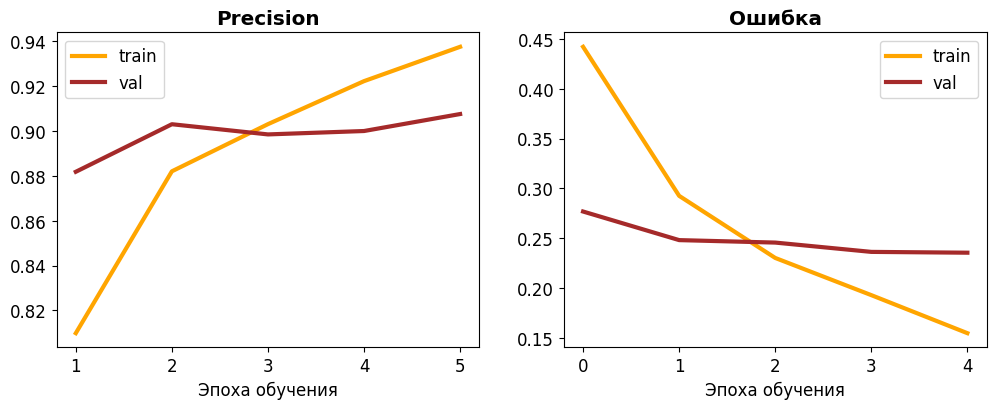

In [ ]:
plot_graph(
    model.history.history["precision"],
    model.history.history["val_precision"],
    model.history.history["loss"],
    model.history.history["val_loss"],
)